# Hierarchical regression

_Author: Christoph Rahmede_

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1">Load the data</a></span></li><li><span><a href="#Dummify-origin-column" data-toc-modified-id="Dummify-origin-column-2">Dummify origin column</a></span></li><li><span><a href="#Choose-target-and-predictors" data-toc-modified-id="Choose-target-and-predictors-3">Choose target and predictors</a></span></li><li><span><a href="#Regression-on-a-single-variable" data-toc-modified-id="Regression-on-a-single-variable-4">Regression on a single variable</a></span><ul class="toc-item"><li><span><a href="#Scikit-Learn" data-toc-modified-id="Scikit-Learn-4.1">Scikit-Learn</a></span></li></ul></li><li><span><a href="#Unpooled-model" data-toc-modified-id="Unpooled-model-5">Unpooled model</a></span></li><li><span><a href="#Hierarchical-model" data-toc-modified-id="Hierarchical-model-6">Hierarchical model</a></span><ul class="toc-item"><li><span><a href="#Posterior-predictive-samples" data-toc-modified-id="Posterior-predictive-samples-6.1">Posterior predictive samples</a></span></li><li><span><a href="#Forest-plot" data-toc-modified-id="Forest-plot-6.2">Forest plot</a></span></li><li><span><a href="#Trace-plots" data-toc-modified-id="Trace-plots-6.3">Trace plots</a></span></li></ul></li></ul></div>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
import pymc3 as pm
import arviz as az

## Load the data

In [4]:
df = pd.read_csv(
    '/Users/maartenk/Documents/git/DsMasterClass/dataset-collection/auto-mpg/auto-mpg.csv', sep='\s+', header=None)
df.columns = ['mpg', 'cylinders', 'displacement', 'horsepower',
              'weight', 'acceleration', 'year', 'origin', 'name']
df.drop(df[df.horsepower == '?'].index, inplace=True)
df.reset_index(inplace=True)
df['horsepower'] = df.horsepower.astype(float)
df['brand'] = df.name.map(lambda x: x.split(' ')[0]
                          ).replace(
    {'toyouta': 'toyota',
     'maxda': 'mazda',
     'chevroelt': 'chevrolet',
     'vw': 'volkswagen',
     'vokswagen': 'volkswagen',
     'mercedes-benz': 'mercedes'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 11 columns):
index           392 non-null int64
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null float64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
brand           392 non-null object
dtypes: float64(5), int64(4), object(2)
memory usage: 33.8+ KB


In [5]:
df.head()

,index,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,brand
0,0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,chevrolet
1,1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320,buick
2,2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite,plymouth
3,3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,amc
4,4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino,ford


## Dummify origin column

In [6]:
df['american'] = df.origin.map(lambda x: 1 if x == 1 else 0)
df['european'] = df.origin.map(lambda x: 1 if x == 2 else 0)
df['asian'] = df.origin.map(lambda x: 1 if x == 3 else 0)

american_mpg = df.mpg[df.american == 1]
european_mpg = df.mpg[df.european == 1]
asian_mpg = df.mpg[df.asian == 1]

In [7]:
df.head()

,index,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,brand,american,european,asian
0,0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,chevrolet,1,0,0
1,1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320,buick,1,0,0
2,2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite,plymouth,1,0,0
3,3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,amc,1,0,0
4,4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino,ford,1,0,0


## Choose target and predictors

It is important to standardize the variables. Although we just do linear regression, the MCMC sampling will run into trouble if the variables are not scaled.

In [8]:
target = 'mpg'
predictors = ['horsepower']

In [9]:
from sklearn.preprocessing import StandardScaler
X = df[predictors]
y = df[target]

# Rescaling will allow us to use the same standard deviation for all
# the beta coefficient priors

scaler = StandardScaler()
Xs = scaler.fit_transform(X)
Xs = pd.DataFrame(Xs, columns=X.columns)

## Regression on a single variable

### Scikit-Learn

Fit a scikit-learn model for comparison.

In [10]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(Xs[predictors], y)
print(lr.score(Xs[predictors], y))
print(lr.intercept_, lr.coef_[0])

0.6059482578894348
23.445918367346938 -6.06787240338099


## Unpooled model

In [11]:
n_groups = len(df.origin.unique())
group_index = (df.origin-1).values
 

shift the origin by 1 to allow for the drop-first from dummyfying.  With drop 1st if neither is true just the intercept + non dummyfied features determine the outcome. This allows the model to apply just these to the dropped class

In [12]:
with pm.Model() as unpooled_model:

    # Independent parameters for each origin
    intercept = pm.Normal('intercept', mu=0., sd=100, shape=n_groups)
    beta = pm.Normal('beta', mu=0., sd=100, shape=n_groups)

    # Model error
    epsilon = pm.HalfCauchy('epsilon', beta=5)

    mu = intercept[group_index] + beta[group_index]*Xs['horsepower'].values

    # likelihood
    y_hat = pm.Normal('y_hat', mu=mu, sd=epsilon, observed=y.values)

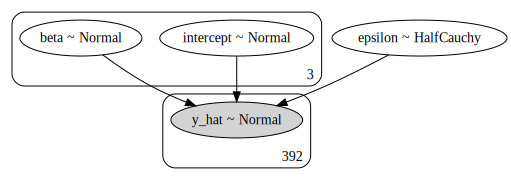

In [13]:
pm.model_to_graphviz(unpooled_model)

In [14]:
with unpooled_model:
    trace_u = pm.sample(2000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta, intercept]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:04<00:00, 2158.71draws/s]


In [15]:
pm.summary(trace_u)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
intercept__0,21.804300,0.299140,0.002879,21.228640,22.394869,8974.308396,0.999949
intercept__1,22.270062,0.840949,0.010941,20.624223,23.913531,5994.242709,0.999974
intercept__2,24.766144,0.866441,0.010695,23.099869,26.501468,5811.368133,1.000071
beta__0,-4.665068,0.281307,0.002978,-5.182617,-4.081604,9289.137499,0.999812
beta__1,-8.560564,1.034565,0.013371,-10.608513,-6.527655,6014.214866,1.000108
beta__2,-8.861810,1.100635,0.013860,-11.084196,-6.792631,5834.756156,0.999898
epsilon,4.430546,0.159363,0.001603,4.130835,4.752536,9870.923755,1.000333


In [15]:
preds = pm.sample_posterior_predictive(trace_u, model=unpooled_model)
pm.r2_score(y.values, preds['y_hat']).r2_mean

100%|██████████| 4000/4000 [00:02<00:00, 1584.36it/s]


0.61

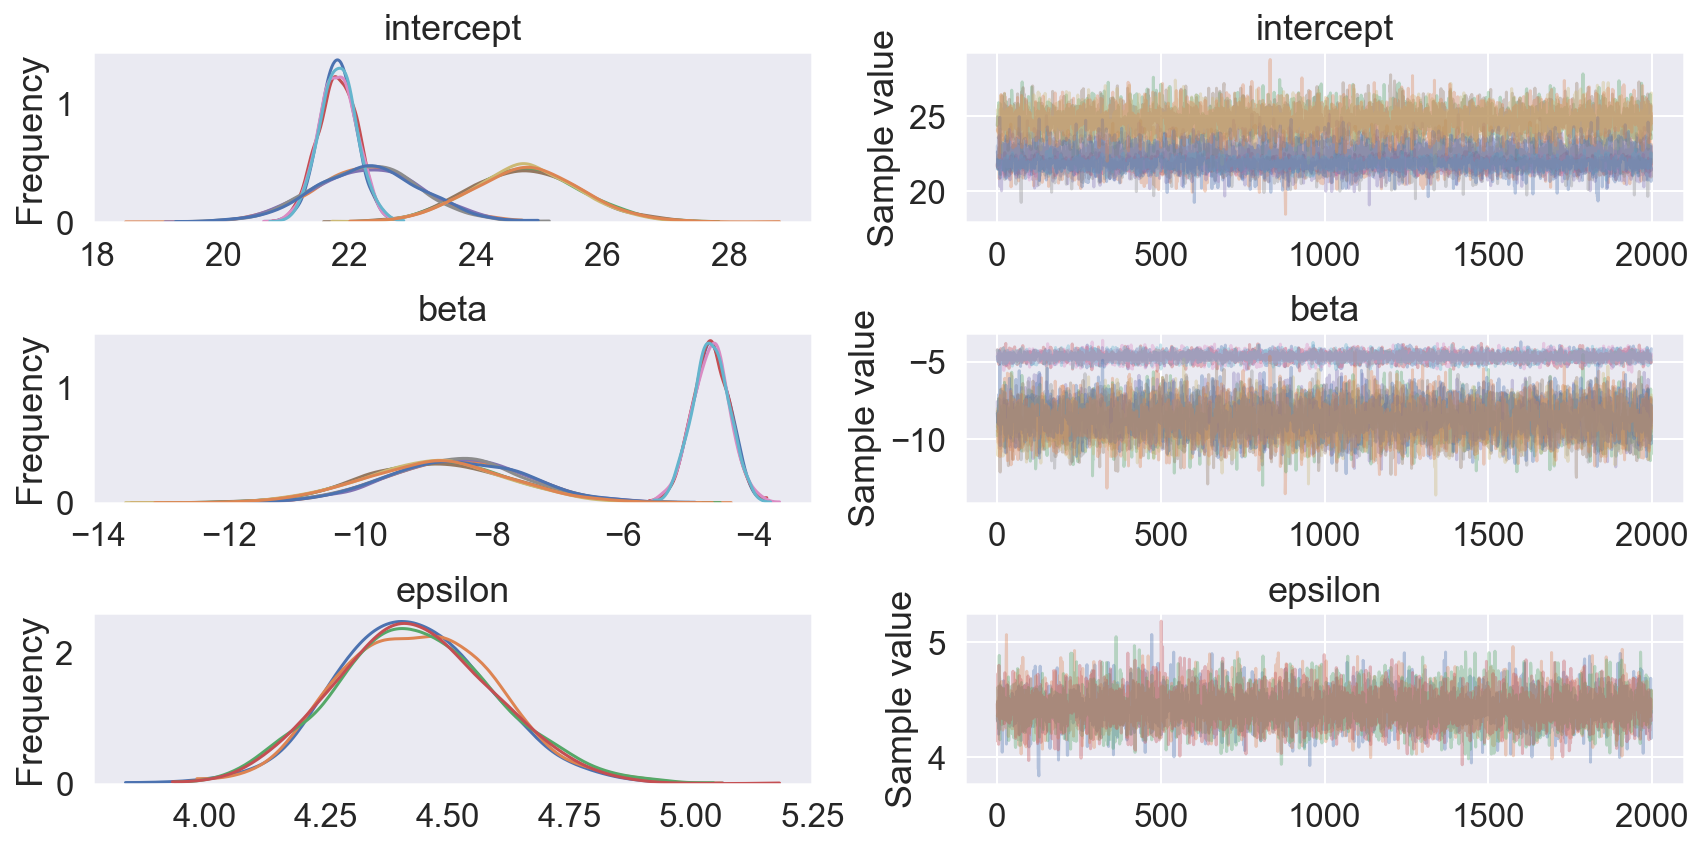

In [16]:
pm.traceplot(trace_u)
plt.show()

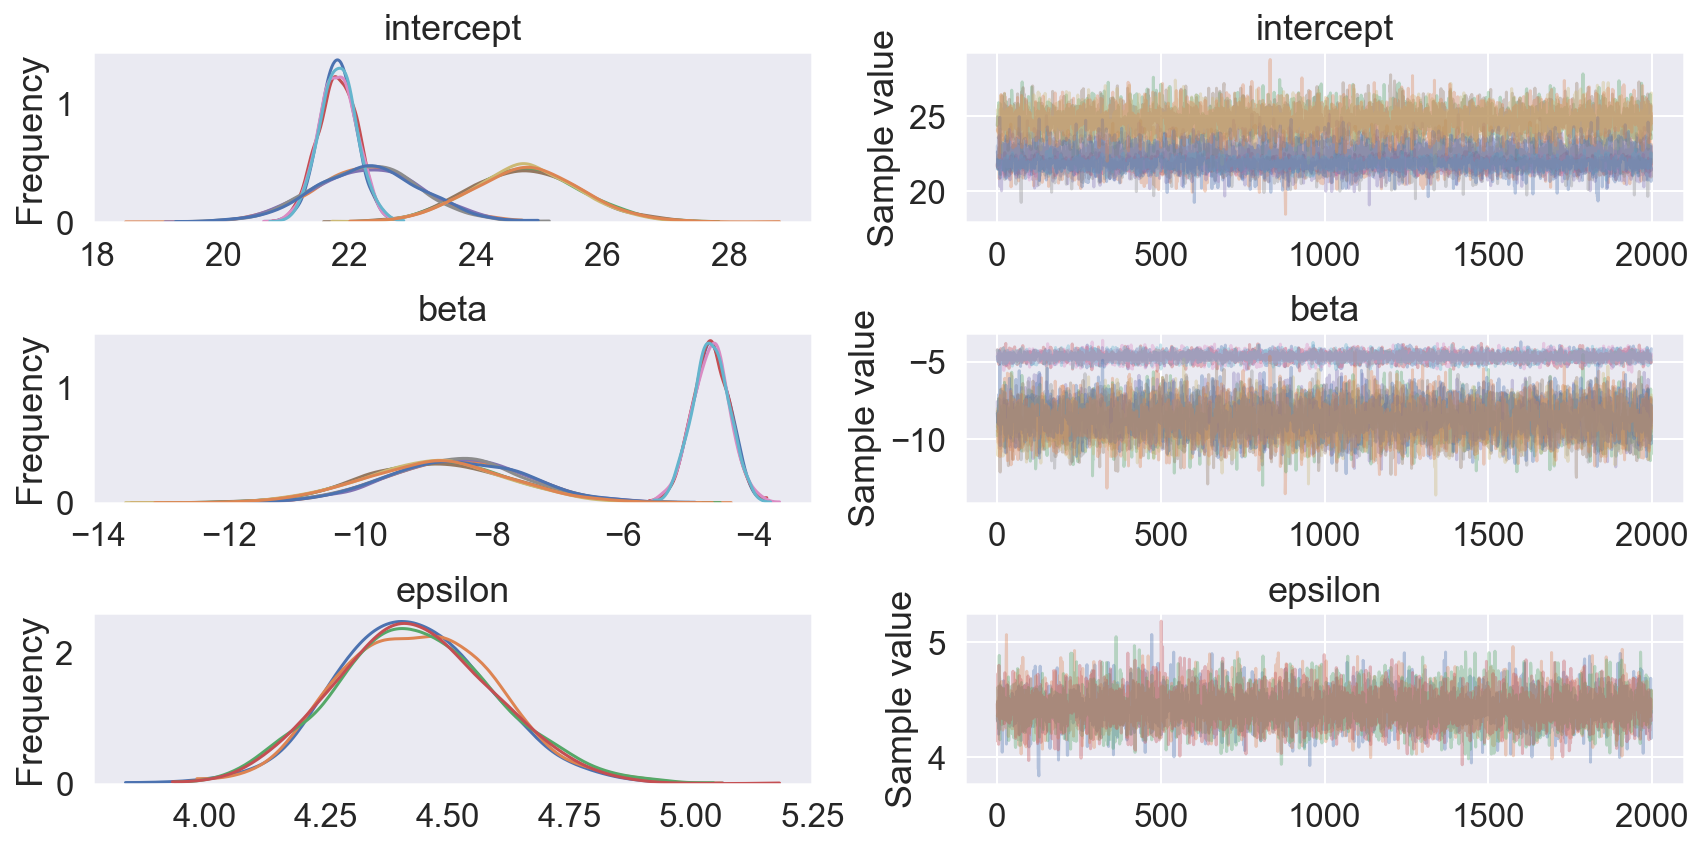

In [17]:
pm.traceplot(trace_u)
plt.show()

## Hierarchical model

In [18]:
with pm.Model() as hierarchical_model:

    # Hyperpriors 
    mu_intercept = pm.Normal('mu_intercept', mu=y.mean(), sd=20)
    mu_beta = pm.Normal('mu_beta', mu=0., sd=20)
    
    # Independent parameters for each origin
    intercept = pm.Normal('intercept', mu=mu_intercept, sd=20, shape=n_groups)
    beta = pm.Normal('beta', mu=mu_beta, sd=20, shape=n_groups)

    # Model error
    eps = pm.Uniform('eps', lower=0.001, upper=20)

    
    mu = intercept[df.origin.values-1] + beta[df.origin.values-1]*Xs.horsepower.values

    # Data likelihood
    y_hat = pm.Normal('y_hat', mu=mu, sd=eps, observed=y.values)

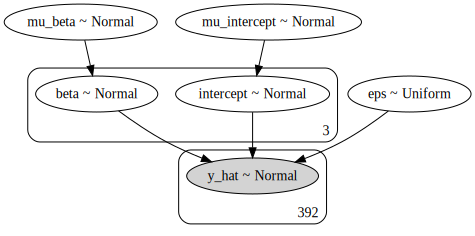

In [19]:
pm.model_to_graphviz(hierarchical_model)

In [20]:
with hierarchical_model:
    trace_hm = pm.sample(2000, nuts_kwargs={'target_accept':0.95}, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta, intercept, mu_beta, mu_intercept]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:13<00:00, 1486.70draws/s]


In [21]:
pm.summary(trace_hm)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_intercept,23.088071,10.041354,0.099538,3.768855,42.936111,9393.861044,1.000182
mu_beta,-5.606858,9.904350,0.093422,-24.855248,13.868851,11170.252329,0.999783
intercept__0,21.806156,0.302223,0.003548,21.211393,22.395381,8495.426438,1.000617
intercept__1,22.307599,0.855632,0.009730,20.618201,23.959103,8254.343012,0.999956
intercept__2,24.791582,0.845444,0.009107,23.202251,26.520143,7568.521810,0.999801
beta__0,-4.662505,0.276634,0.002780,-5.192687,-4.131438,9673.208211,1.000172
beta__1,-8.520530,1.058507,0.011455,-10.476852,-6.325040,8292.188023,0.999931
beta__2,-8.835661,1.066909,0.012154,-10.937688,-6.777365,7665.276636,0.999996
eps,4.435361,0.158542,0.001640,4.153078,4.766556,11377.403283,0.999753


### Posterior predictive samples

In [22]:
preds = pm.sample_posterior_predictive(trace_hm, model=hierarchical_model)
pm.r2_score(y.values, preds['y_hat']).r2_mean

100%|██████████| 8000/8000 [00:04<00:00, 1624.07it/s]


0.61

In [23]:
preds['y_hat'].shape

(8000, 392)

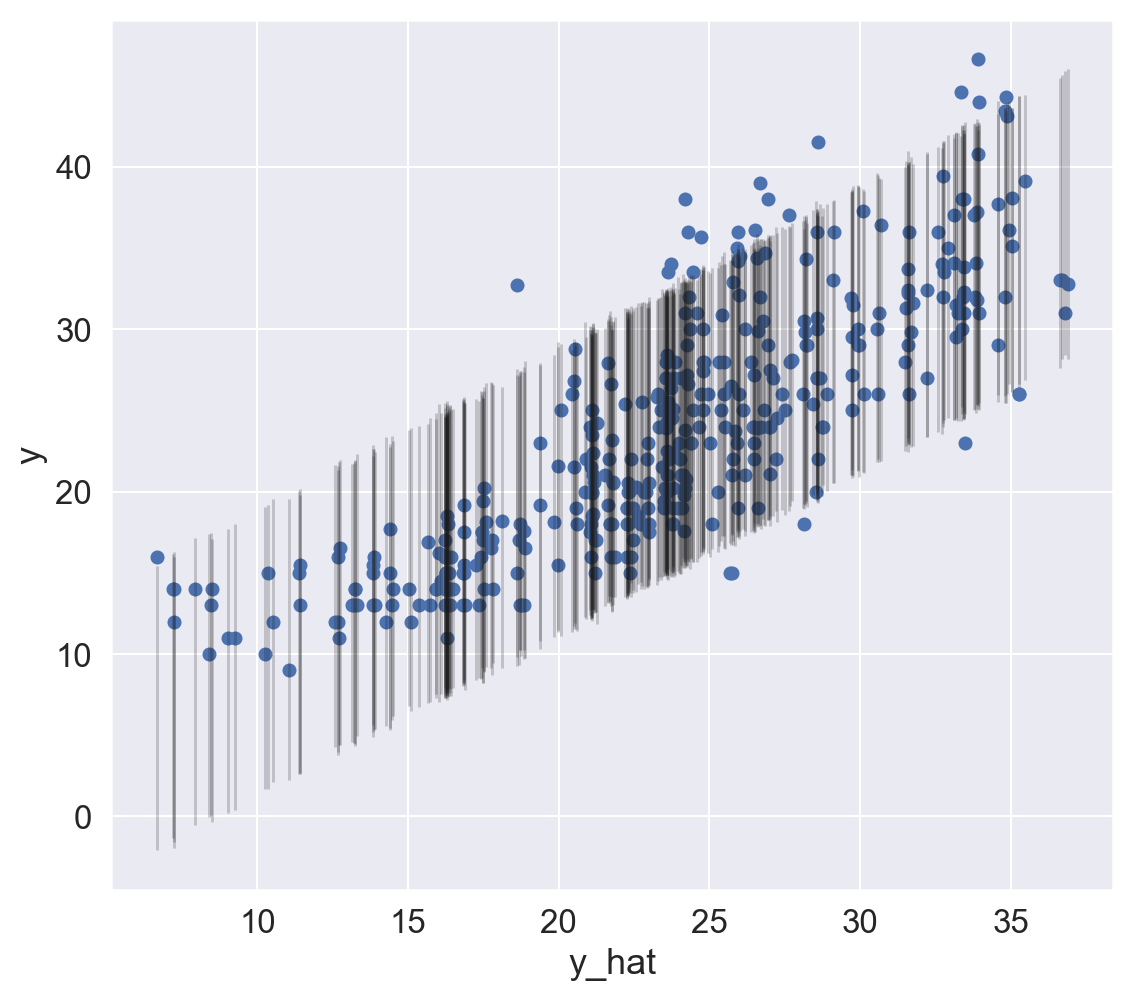

In [24]:
predictions = preds['y_hat'].mean(axis=0)
hpds = np.apply_along_axis(pm.hpd, 0, preds['y_hat']).T

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(predictions, y)
for i in range(len(y)):
    ax.vlines(predictions[i], hpds[i, 0], hpds[i, 1], alpha=0.2)
ax.set_xlabel('y_hat')
ax.set_ylabel('y')
plt.show()

### Forest plot

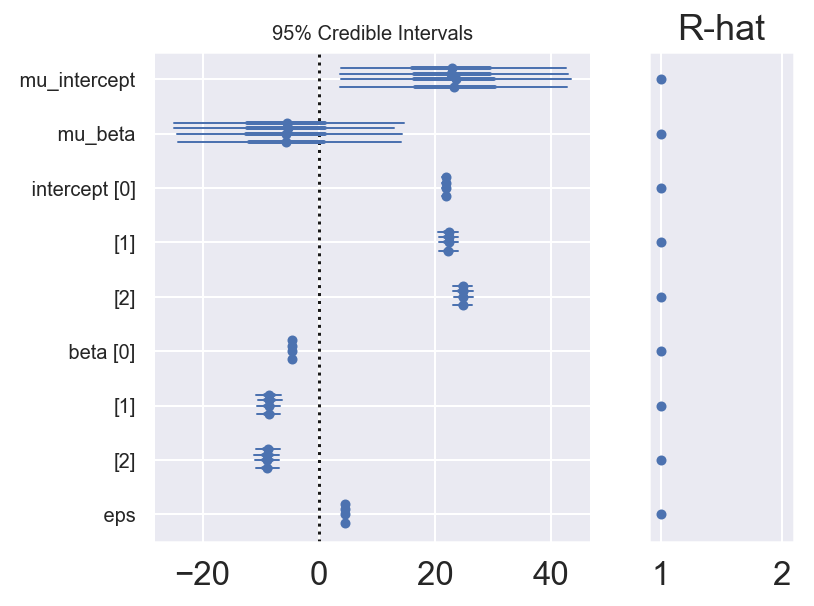

In [25]:
pm.forestplot(trace_hm)
plt.show()

### Trace plots

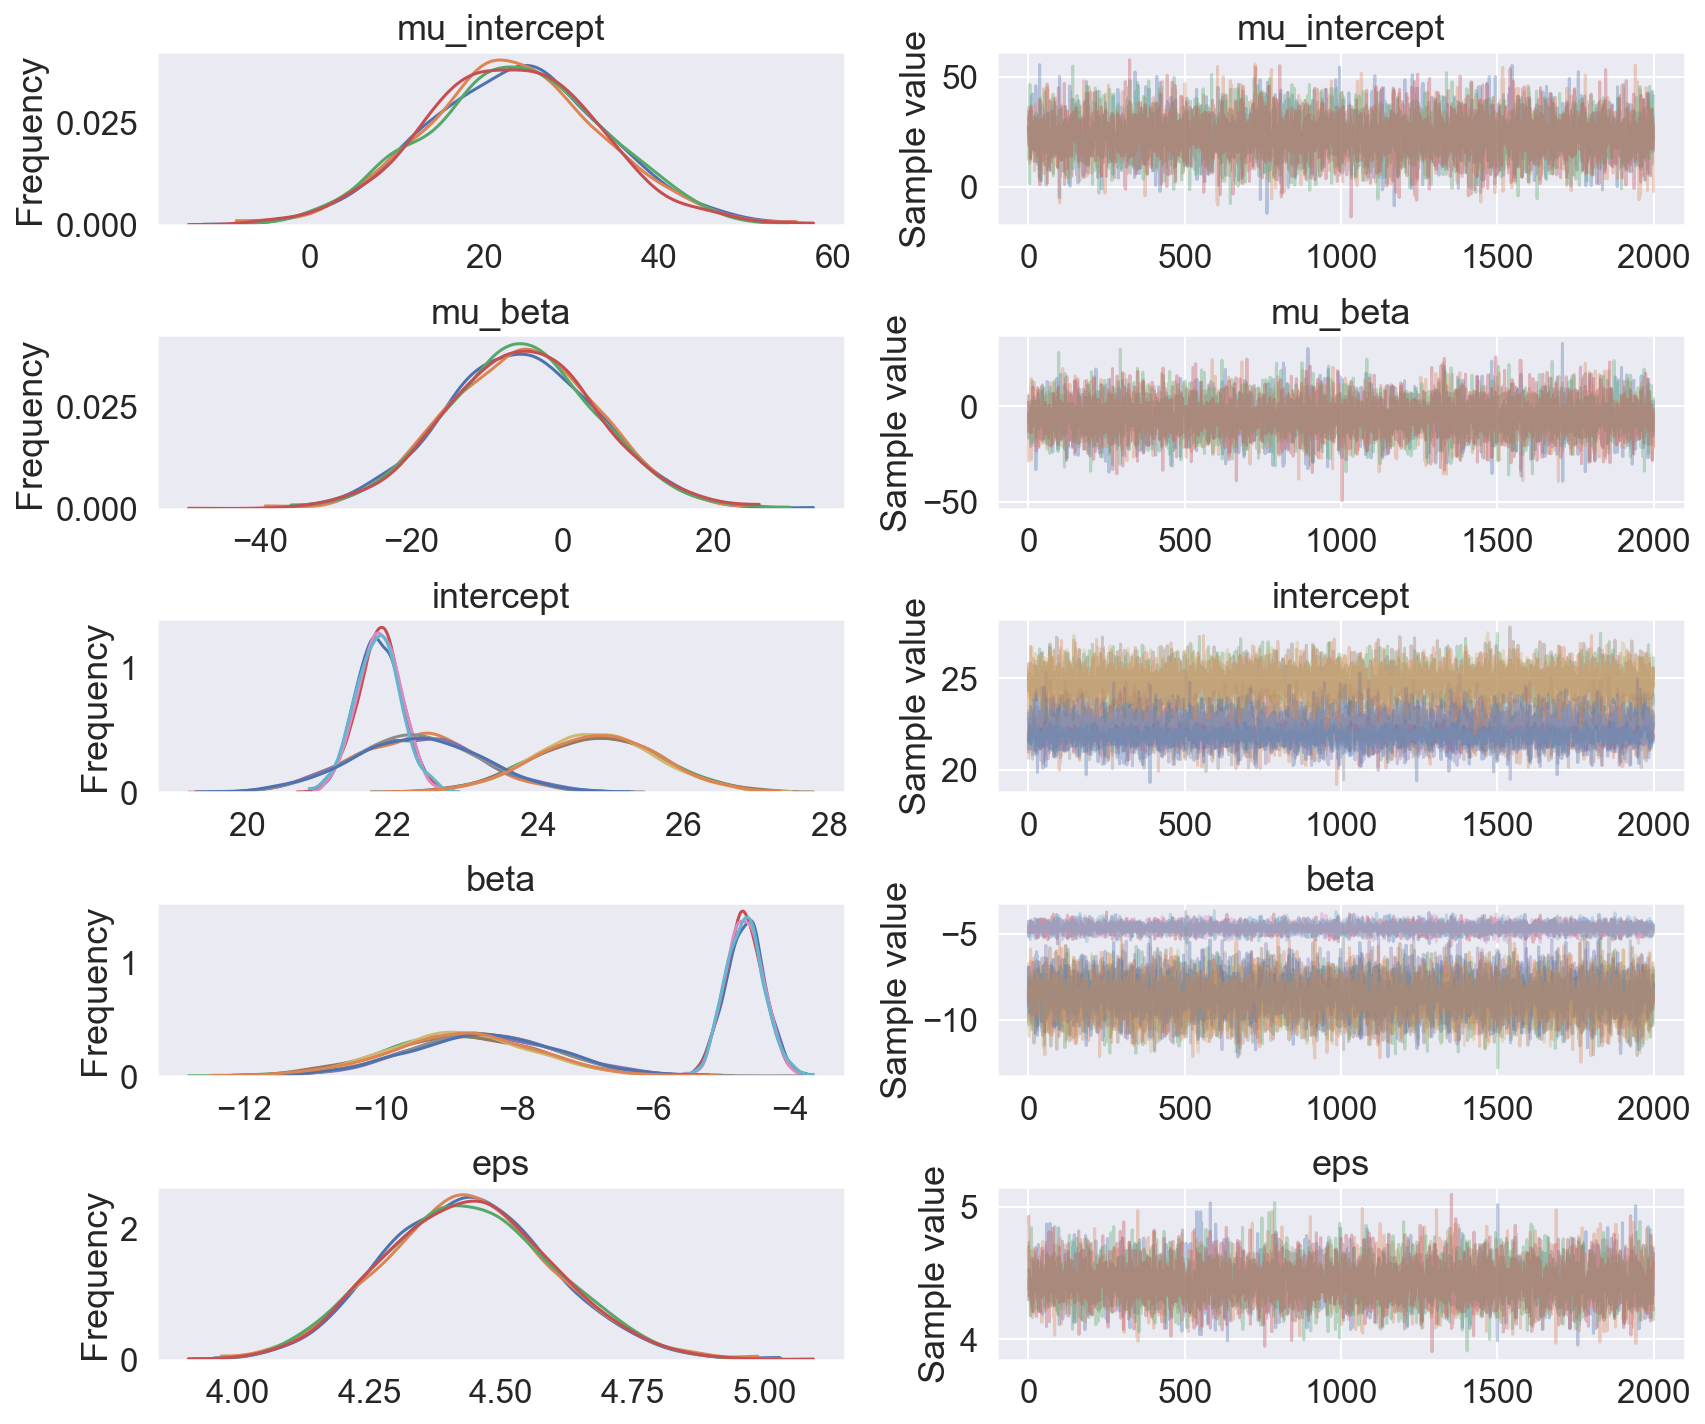

In [26]:
pm.traceplot(trace_hm)
plt.show()

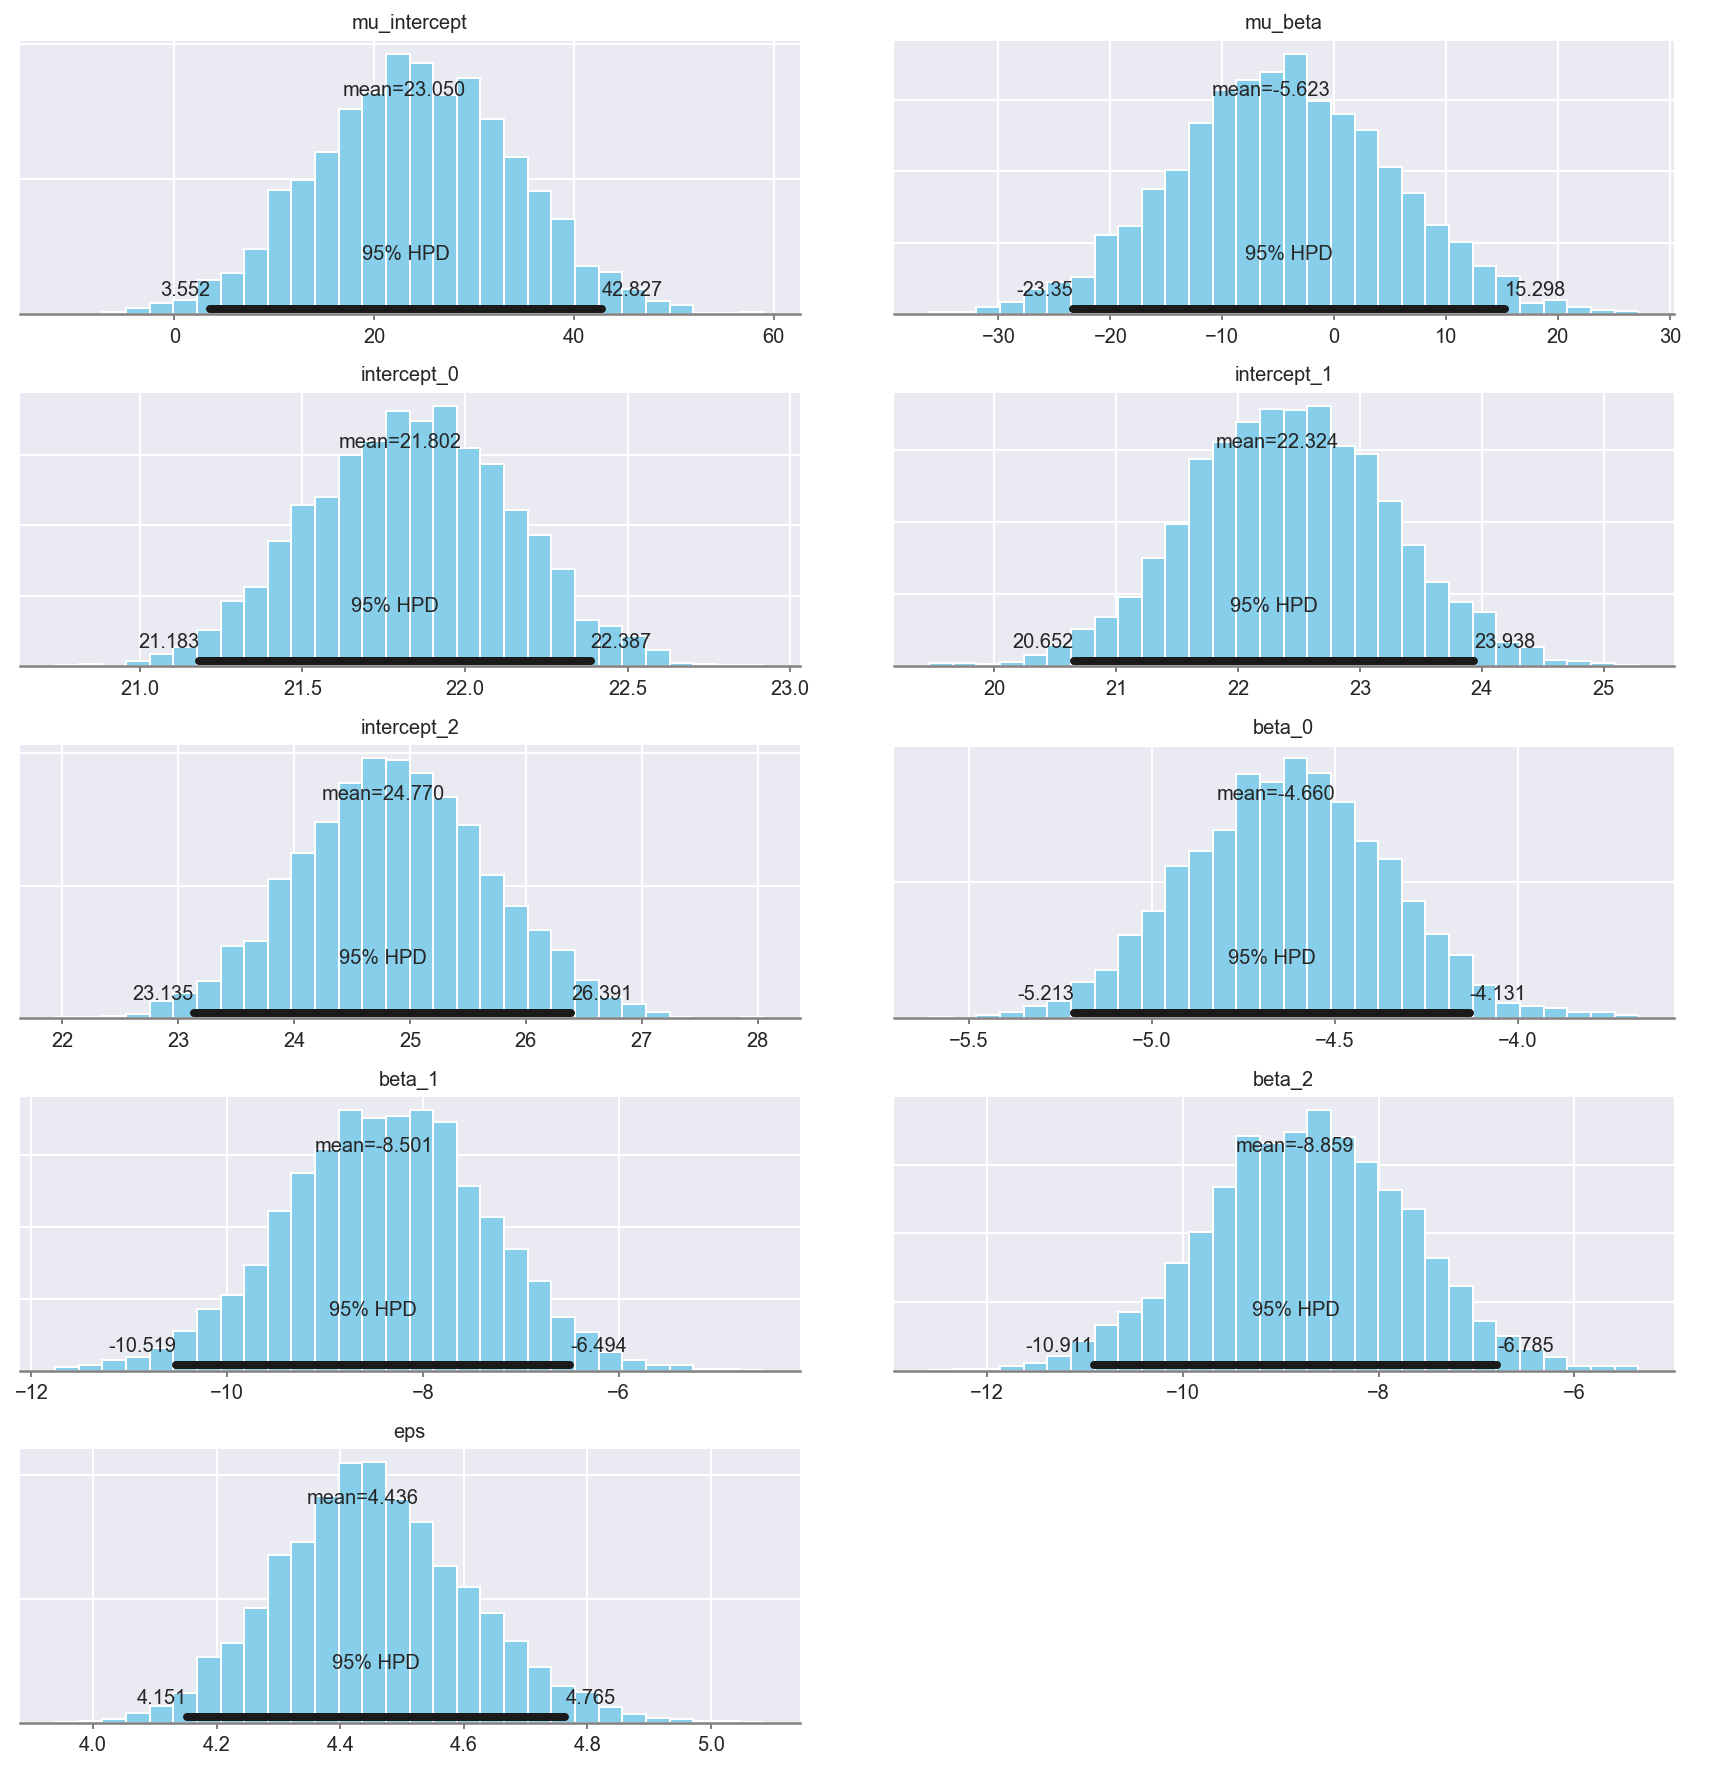

In [27]:
pm.plot_posterior(trace_hm)
plt.show()